In [6]:
import pandas as pd
import numpy as np
data=pd.read_csv("/content/drive/MyDrive/machine failure.csv")
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd

# Drop the specified columns
data_cleaned = data.drop(columns=['UDI', 'Product ID', 'Type'])

# Define a function to identify outliers using the IQR method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Detect outliers in the specified columns
outliers_rotational_speed = detect_outliers(data_cleaned, 'Rotational speed [rpm]')
outliers_torque = detect_outliers(data_cleaned, 'Torque [Nm]')
outliers_tool_wear = detect_outliers(data_cleaned, 'Tool wear [min]')

# Print count of outliers in each column
outliers_count = {
    'Rotational speed [rpm]': outliers_rotational_speed.shape[0],
    'Torque [Nm]': outliers_torque.shape[0],
    'Tool wear [min]': outliers_tool_wear.shape[0]
}
print("Outliers Count:", outliers_count)

# Handle outliers by capping them at the upper and lower bounds
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

# Cap outliers in the specified columns
cap_outliers(data_cleaned, 'Rotational speed [rpm]')
cap_outliers(data_cleaned, 'Torque [Nm]')
cap_outliers(data_cleaned, 'Tool wear [min]')

# Verify changes
print(data_cleaned.describe())


Outliers Count: {'Rotational speed [rpm]': 418, 'Torque [Nm]': 69, 'Tool wear [min]': 0}
       Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
count         10000.000000             10000.000000            10000.000000   
mean            300.004930               310.005560             1530.142500   
std               2.000259                 1.483734              148.798499   
min             295.300000               305.700000             1168.000000   
25%             298.300000               308.800000             1423.000000   
50%             300.100000               310.100000             1503.000000   
75%             301.500000               311.100000             1612.000000   
max             304.500000               313.800000             1895.500000   

        Torque [Nm]  Tool wear [min]  Machine failure           TWF  \
count  10000.000000     10000.000000     10000.000000  10000.000000   
mean      39.983490       107.951000         0.033900    

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from keras.layers import LeakyReLU

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from keras.layers import LeakyReLU

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd

# Split features and target
X = data_cleaned.drop(columns=['Machine failure'])
y = data_cleaned['Machine failure']
y = shuffle(y, random_state=47)
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance the dataset if it is imbalanced
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Print shapes of the datasets
print(f'Training set shape: X={X_train.shape}, y={y_train.shape}')
print(f'Testing set shape: X={X_test.shape}, y={y_test.shape}')

# Now the data is preprocessed and ready for model training.


Training set shape: X=(15457, 10), y=(15457,)
Testing set shape: X=(3865, 10), y=(3865,)


In [12]:
from tensorflow.keras.regularizers import l2
model=Sequential()
model.add(Dense(47,activation='relu',input_dim=10,kernel_regularizer=l2(0.001)))
model.add(Dense(64,activation='relu',))
model.add(Dropout(0.25))
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu',kernel_regularizer=l2(0.003)))
model.add(Dropout(0.15))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history=model.fit(X_train,y_train,epochs=3500,validation_data=(X_test, y_test))

Streaming output truncated to the last 5000 lines.
484/484 [==============================] - 3s 5ms/step - loss: 0.2335 - accuracy: 0.9200 - val_loss: 0.2709 - val_accuracy: 0.9115
Epoch 1002/3500
484/484 [==============================] - 2s 5ms/step - loss: 0.2397 - accuracy: 0.9180 - val_loss: 0.2504 - val_accuracy: 0.9193
Epoch 1003/3500
484/484 [==============================] - 2s 5ms/step - loss: 0.2308 - accuracy: 0.9227 - val_loss: 0.2406 - val_accuracy: 0.9203
Epoch 1004/3500
484/484 [==============================] - 2s 4ms/step - loss: 0.2319 - accuracy: 0.9245 - val_loss: 0.2296 - val_accuracy: 0.9268
Epoch 1005/3500
484/484 [==============================] - 2s 4ms/step - loss: 0.2302 - accuracy: 0.9229 - val_loss: 0.2414 - val_accuracy: 0.9198
Epoch 1006/3500
484/484 [==============================] - 2s 4ms/step - loss: 0.2354 - accuracy: 0.9201 - val_loss: 0.2485 - val_accuracy: 0.9141
Epoch 1007/3500
484/484 [==============================] - 2s 4ms/step - loss: 0.23

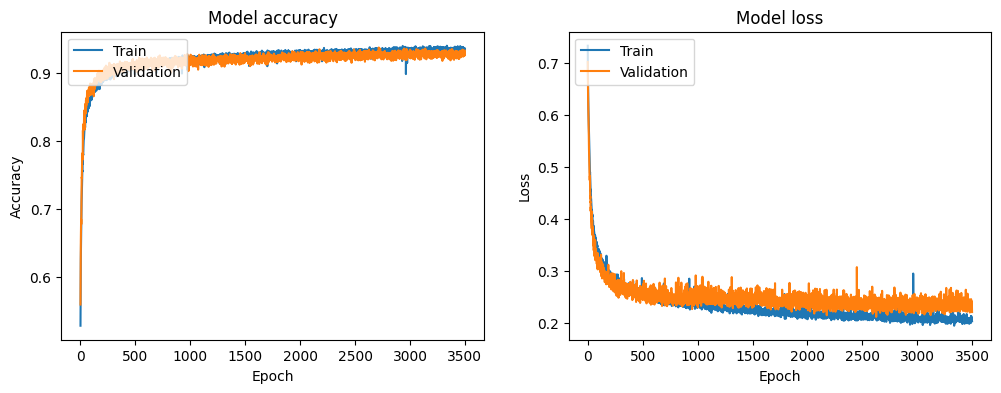

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Assuming you have your model's history object
plot_training_history(history)


121/121 [==============================] - 1s 2ms/step


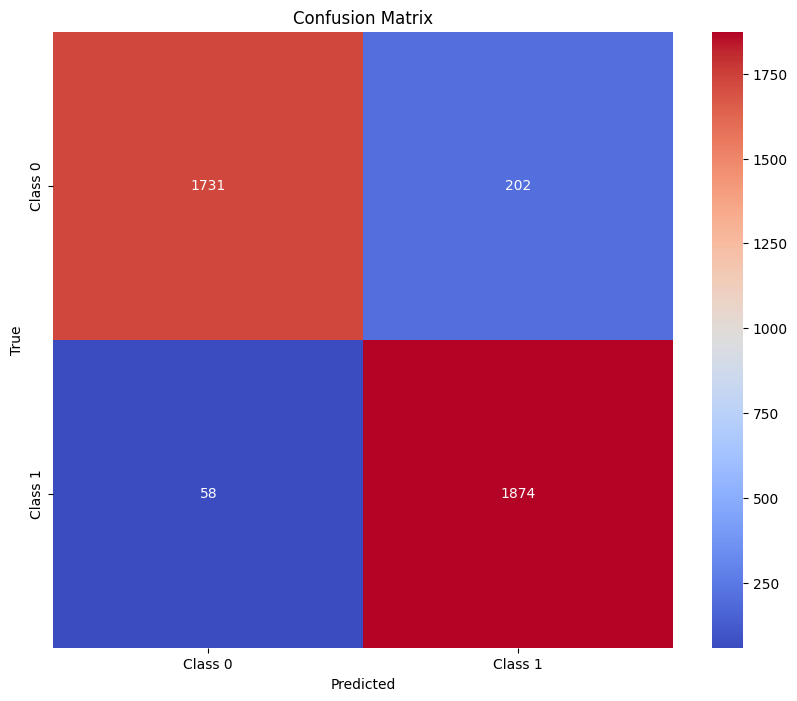

In [14]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, class_names):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Predict class labels (binary classification example)
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Replace with your actual class names
class_names = ['Class 0', 'Class 1']

# Plotting the confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names)

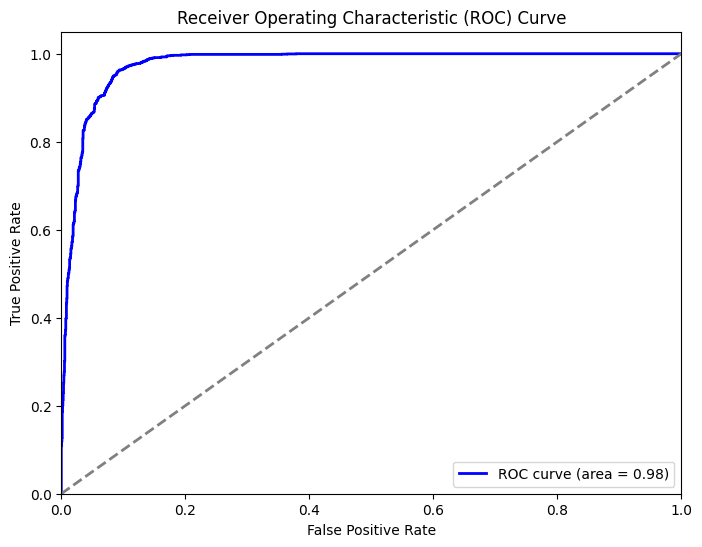

In [15]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, y_pred_probs):
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Assuming y_pred_probs are the predicted probabilities for the positive class
plot_roc_curve(y_test, y_pred_probs)


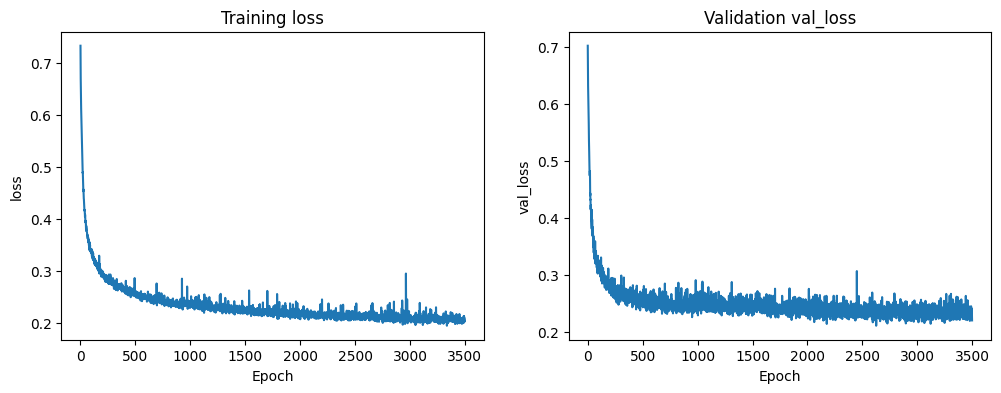

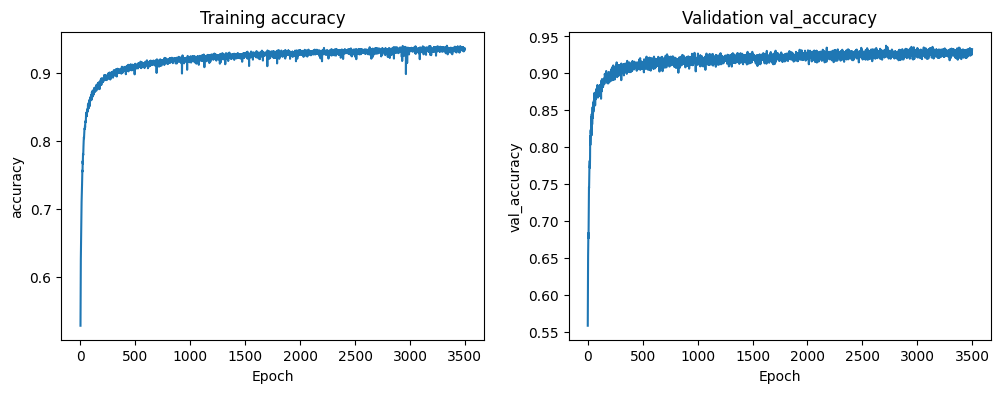

In [16]:
def plot_side_by_side(history):
    keys = history.history.keys()
    metrics = [key for key in keys if not key.startswith('val_')]

    for metric in metrics:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history[metric])
        plt.title(f'Training {metric}')
        plt.xlabel('Epoch')
        plt.ylabel(metric)

        val_metric = f'val_{metric}'
        if val_metric in keys:
            plt.subplot(1, 2, 2)
            plt.plot(history.history[val_metric])
            plt.title(f'Validation {val_metric}')
            plt.xlabel('Epoch')
            plt.ylabel(val_metric)

        plt.show()

# Plot side-by-side training and validation metrics
plot_side_by_side(history)


In [17]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1731  202]
 [  58 1874]]
0.9327296248382924
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      1933
           1       0.90      0.97      0.94      1932

    accuracy                           0.93      3865
   macro avg       0.94      0.93      0.93      3865
weighted avg       0.94      0.93      0.93      3865



In [18]:
y_pred = model.evaluate(X_test,y_test)[1]

121/121 [==============================] - 0s 3ms/step - loss: 0.2207 - accuracy: 0.9327
